In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
print(sklearn.__version__)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

0.23.2
/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [33]:
!pip install sklearn -U

# Introduction

In this notebook, I'll try to bring some insights and explanation on a ML model using XAI techniques. Since my goal is to exercise and improve my skills and knowledge about XAI, in this notebook I'm going to focus on these things. For this reason I'm not going to put much effort on model tuning or other fundamental tasks.

For this purpose, I've chosen the *telco-customer-churn* dataset. A Churn Model is in my opinion a good use case for XAI. Indeed, it allows to address few tasks based on XAI:

- Address model fairness and feature impact on target
- Explain (locally) a prediction
- Find counterfactuals



This notebook is organized as follows:
1) In the **First Section**, I retrieve data, summarise some statistical info and apply basic cleaning to the raw dataset;

2) In the **Second Section**, I focus on build some classifiers and validate the using the Precision-Recall curve;

3) In the **Last Section**, I choose one of the classifiers and provide some insights on it. Even if some of the technique may be model-specific, this section mainly use model-agnostic methods.

Some useful libraries that I've been exploring for this notebook:
- [Scikit-learn Inspection submodule](https://scikit-learn.org/stable/inspection.html): it is rather interesting and useful. However, there are issues due to the wrong version which is available on Kaggle.
- [Shap](https://shap.readthedocs.io/en/latest/index.html)
- [LIME - by marcotcr](https://github.com/marcotcr/lime)
- [alibi - by SeldonIO](https://github.com/SeldonIO/alibi)
- [DiCE - by interpretml](https://github.com/interpretml/DiCE)

## Section I - Retrieve Data

In [34]:
import numpy as np

import sklearn

pd.options.display.max_columns = 500 # this will set limit of columns to 500

In [35]:
file_path = '../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(file_path)

In [36]:
for column in df.columns:
    print(column)
    
label = ['Churn']

ID = ['customerID']

features = [column for column in df.columns if column not in label+ID]
print('DataFrame - Telco Customer Churn\n')
print(df.info())
print('\n')
print(df.head(5))

for column in df.columns:
    print('\n')
    print(column+' - number of unique elements: ', df.loc[:,column].nunique())
    
df2 = df.loc[:,(df.nunique()==2)|(df.nunique()==4)].copy()
nrows = df2.shape[0]
for column in df2.columns:
    print(column+'\n')
    print(df2[column].unique())
    print('\n')
    print(df2[column].value_counts()/nrows*100)
    print('\n#########################\n')
    
df3 = df.loc[:,(df.nunique()==3)].copy()
nrows = df3.shape[0]
for column in df3.columns:
    print(column+'\n')
    print(df3[column].unique())
    print('\n')
    print(df3[column].value_counts()/nrows*100)
    print('\n#########################\n')

customerID
gender
SeniorCitizen
Partner
Dependents
tenure
PhoneService
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaperlessBilling
PaymentMethod
MonthlyCharges
TotalCharges
Churn
DataFrame - Telco Customer Churn

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-nul

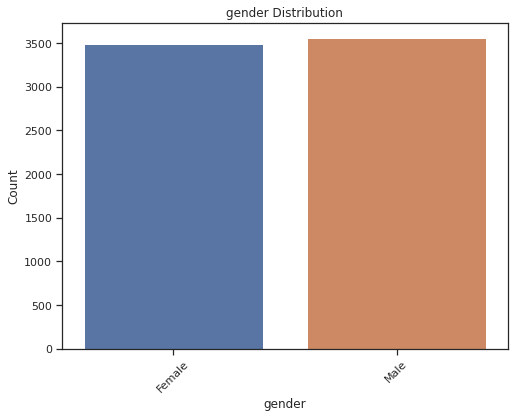

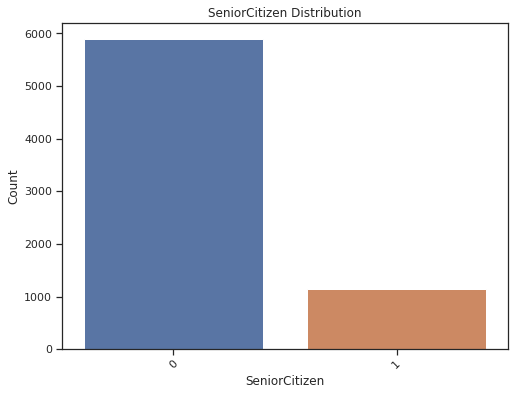

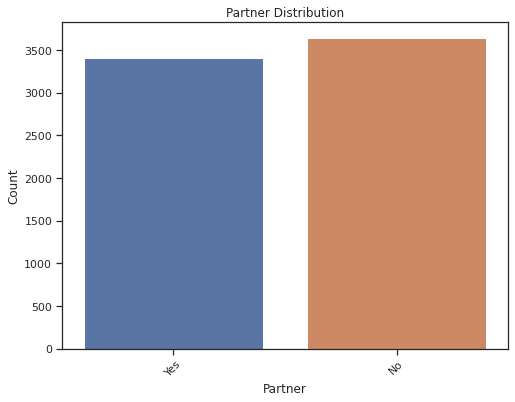

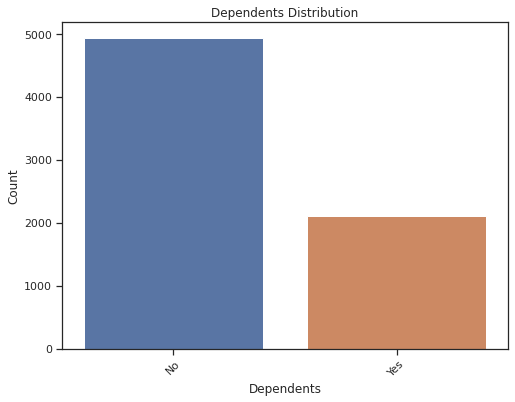

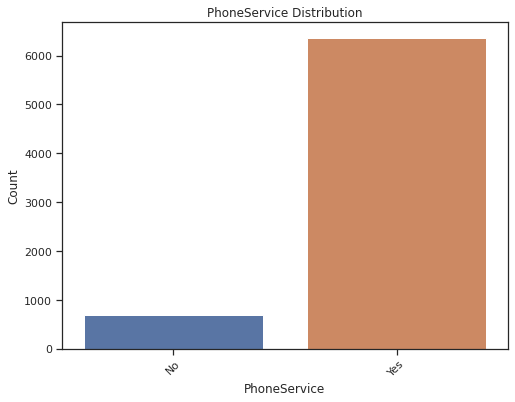

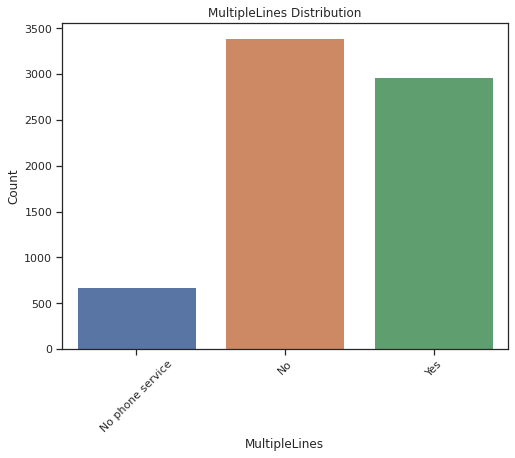

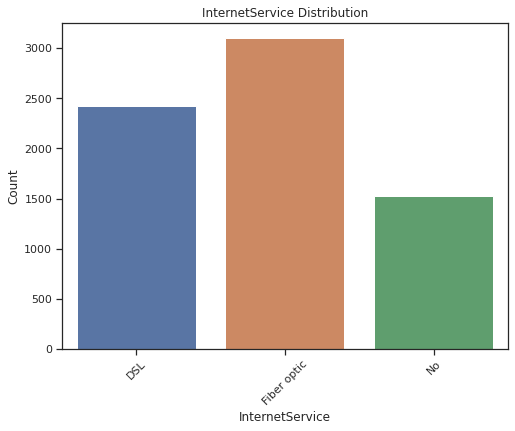

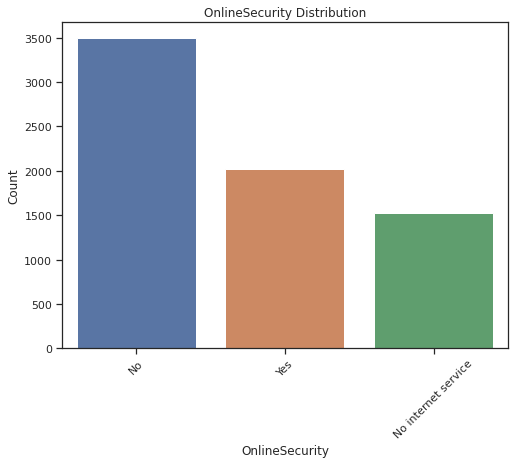

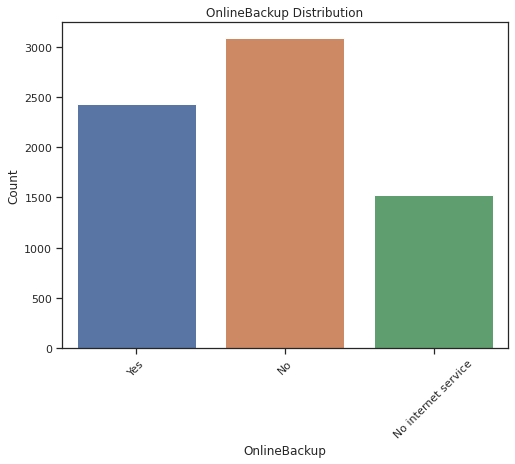

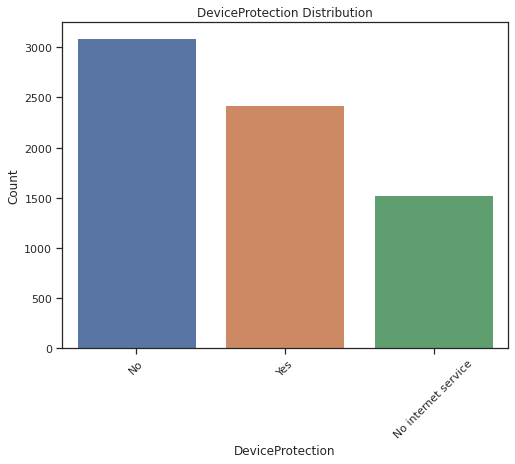

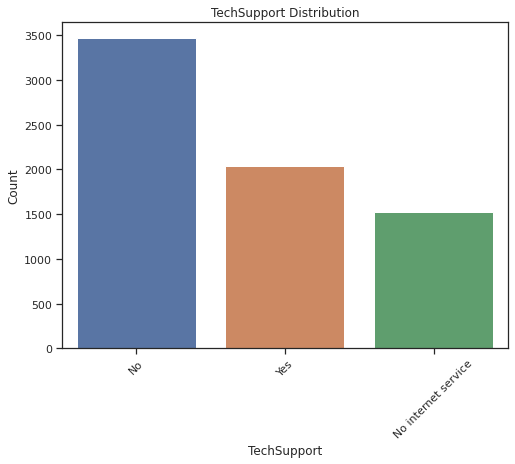

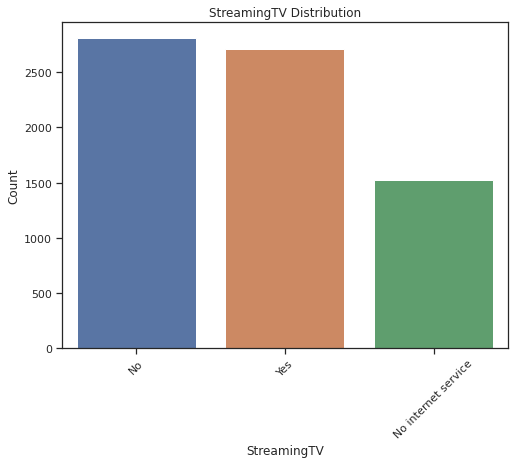

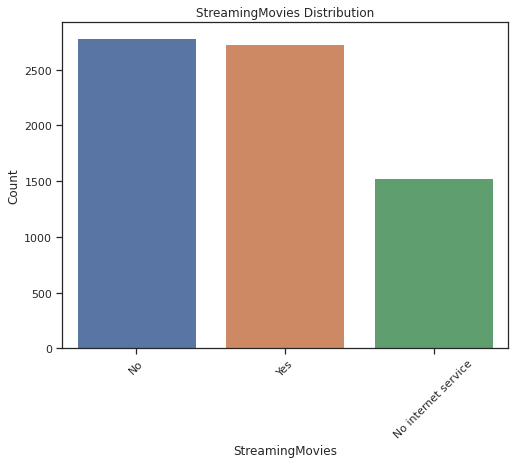

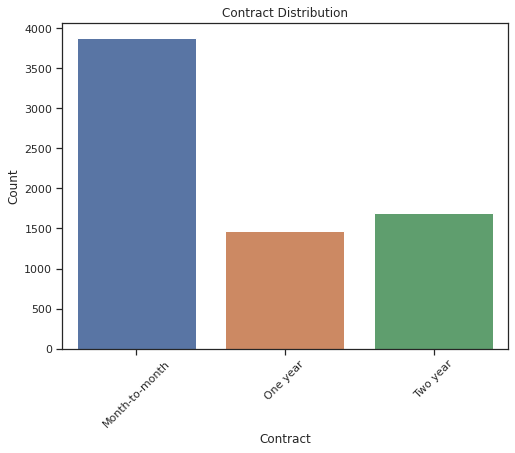

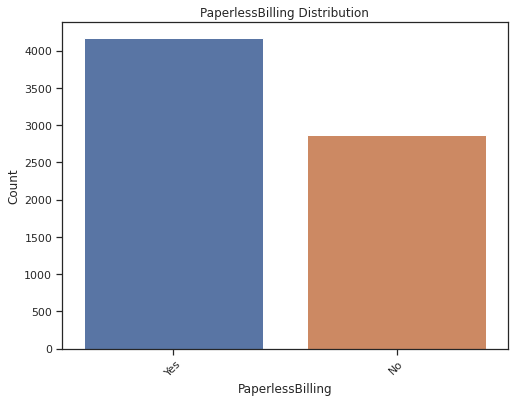

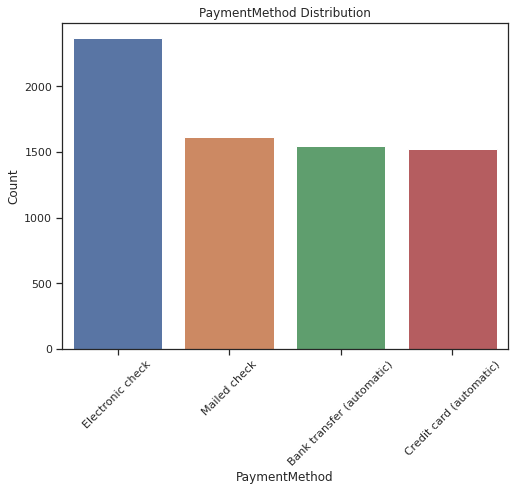

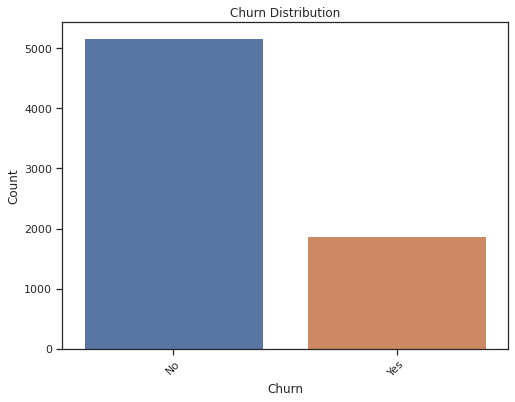

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the list of columns you want to visualize
columns_to_visualize = df.columns

# Loop through the columns and create bar plots for those with a small number of unique values
for column in columns_to_visualize:
    if df[column].nunique() <= 10:
        plt.figure(figsize=(8, 6))
        sns.countplot(data=df, x=column)
        plt.title(f'{column} Distribution')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
        plt.show()


#### Basic cleaning for TotalCharges

The total charges are missing if the tenure is equal to 0. Hence, we replace null values with 0s.

In [37]:
df.TotalCharges = df.TotalCharges.replace(' ', 0).astype(float)

### Splitting Dataset

In [38]:
def StratifiedSplitting(X: pd.DataFrame):
    from sklearn.model_selection import train_test_split
    return sklearn.model_selection.train_test_split(X,test_size = 0.2, stratify = X.Churn)

X = df.copy()
X_train, X_val = StratifiedSplitting(X)

### Building New Features

In [39]:
def get_features(df: pd.DataFrame, ID, label):
    return [column for column in df.columns if column not in label+ID]

In [40]:
X = X_train

def build_new_feature(df_churn: pd.DataFrame):
    X = df_churn.copy()
    
    
    
    X['AverageCharges'] = X['TotalCharges']/(X.tenure)
    X['AverageCharges'] = X.AverageCharges.replace([np.inf, -np.inf],np.nan).fillna(X.MonthlyCharges)
    X['PriceChange'] = (X.MonthlyCharges - X.AverageCharges)/(X.AverageCharges)
    X['Years'] = (X.tenure/(12.0)).astype(int)/6
    X['NewCustomer'] = np.where(X.tenure==0,1,0)
    
    X.drop(columns=['TotalCharges','MonthlyCharges','tenure'], inplace = True)
    return X

X = build_new_feature(X)

features = get_features(X, ID, label)

def convert_to_bool(df_churn: pd.DataFrame):
    X = df_churn.copy()
    
    X['gender'] = (X.gender=='Male')
    X['Partner'] = (X.Partner=='Yes')
    X['Dependents'] = (X.Dependents=='Yes')
    
    X['PhoneService'] = (X.PhoneService=='Yes')
    X['MultipleLines'] = (X.MultipleLines=='Yes')
    X['OnlineService'] = (X.OnlineSecurity=='Yes') | (X.OnlineBackup =='Yes')
    X['DeviceProtection'] = (X.DeviceProtection == 'Yes')
    X['TechSupport'] = (X.TechSupport == 'Yes')
    X['Streaming'] = (X.StreamingTV == 'Yes') | (X.StreamingMovies == 'Yes')
    X['PaperlessBilling'] = (X.PaperlessBilling == 'Yes')
    X['Fiber'] = (X.InternetService=='Fiber optic')
    X['M2m'] = (X.Contract=='Month-to-month')
    X['OneYearContract'] = (X.Contract=='One year')
    
    X['NumberInternetServices'] = (X.OnlineSecurity=='Yes')+(X.OnlineBackup =='Yes')+(X.DeviceProtection == 'Yes')+(X.TechSupport == 'Yes')+(X.StreamingTV == 'Yes') + (X.StreamingMovies == 'Yes')
    X['NumberInternetServices'] = X['NumberInternetServices']/6
    
    
    X['AutomaticPayment'] = (X.PaymentMethod=='Bank transfer (automatic)')|(X.PaymentMethod=='Credit card (automatic)')
    X['CreditCard'] = X.PaymentMethod=='Credit card (automatic)'
    X['Mail'] = (X.PaymentMethod=='Mailed check')
    
    X.drop(columns=['PhoneService', 'OnlineSecurity', 'OnlineBackup', 
                    'StreamingTV', 'StreamingMovies','PaymentMethod','InternetService','Contract'], 
           inplace=True)
    
    return X

X = convert_to_bool(X)

def normalize(X, x_min = None, x_max = None):
    if (x_min == None)|(x_max == None):
        x_min = X.min()
        x_max = X.max()
        return (X - x_min)/(x_max - x_min), x_min, x_max
    else:
        return (X - x_min)/(x_max - x_min)

X.AverageCharges, x_min,x_max = normalize(X.AverageCharges)

X_val = convert_to_bool(
    build_new_feature(X_val)
)
X_val.AverageCharges = normalize(X_val.AverageCharges,x_min,x_max)

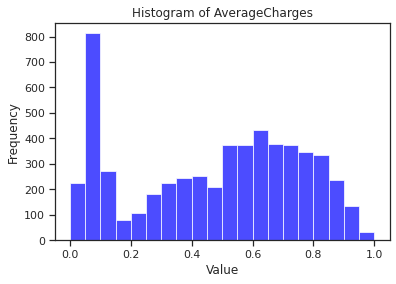

In [65]:
plt.hist(X['AverageCharges'], bins=20, color='blue', alpha=0.7)
plt.title('Histogram of AverageCharges')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


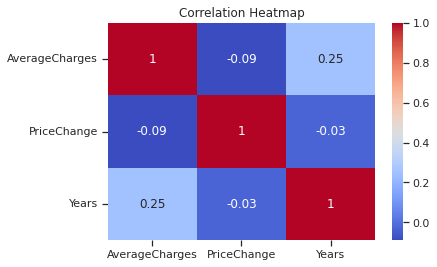

In [66]:
import seaborn as sns

correlation_matrix = X[['AverageCharges', 'PriceChange', 'Years']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


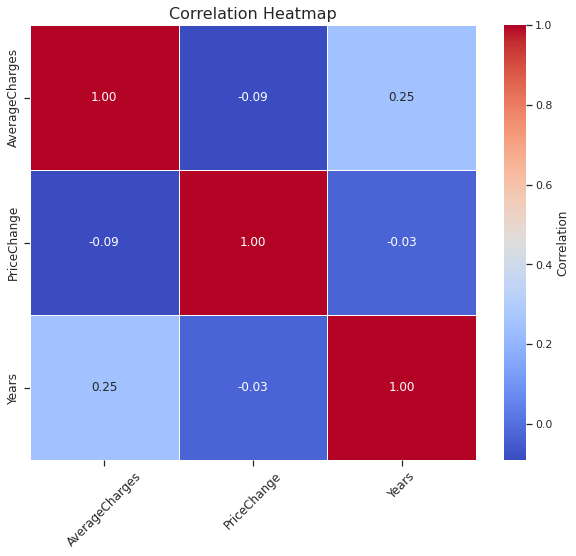

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = X[['AverageCharges', 'PriceChange', 'Years']].corr()

# Create a heatmap with annotations
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0.5)

# Customize the appearance of the heatmap
heatmap.set_title('Correlation Heatmap', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a color bar legend
cbar = heatmap.collections[0].colorbar
cbar.set_label('Correlation', fontsize=12)

# Rotate the tick labels for better readability
plt.xticks(rotation=45)

# Show the heatmap
plt.show()


In [70]:
pip install shap


Note: you may need to restart the kernel to use updated packages.


In [64]:
feature_stats = X[['AverageCharges', 'PriceChange', 'Years']].describe()
print(feature_stats)


       AverageCharges  PriceChange        Years
count     5634.000000  5634.000000  5634.000000
mean         0.474600     0.002225     0.382499
std          0.279505     0.050613     0.336819
min          0.000000    -0.346804     0.000000
25%          0.209243    -0.019006     0.000000
50%          0.526597     0.000000     0.333333
75%          0.709159     0.020798     0.666667
max          1.000000     0.450628     1.000000


In [74]:
import pandas as pd

# Select the features of interest
selected_features = ['AverageCharges', 'PriceChange', 'Years']

# Calculate summary statistics for the selected features
feature_stats = X[selected_features].describe()

# Rename the columns for better clarity
feature_stats = feature_stats.rename(columns={'AverageCharges': 'Average Charges', 'PriceChange': 'Price Change', 'Years': 'Years'})

# Add the median absolute deviation (MAD) as an additional statistic
feature_stats.loc['MAD'] = X[selected_features].mad()

# Round the statistics to two decimal places for better readability
feature_stats = feature_stats.round(2)

# Transpose the table for better presentation
feature_stats = feature_stats.transpose()

# Print the enhanced feature statistics table
print("Feature Statistics:")
print(feature_stats)


Feature Statistics:
                  count  mean   std   min   25%   50%   75%   max  MAD
Average Charges  5634.0  0.47  0.28  0.00  0.21  0.53  0.71  1.00  NaN
Price Change     5634.0  0.00  0.05 -0.35 -0.02  0.00  0.02  0.45  NaN
Years            5634.0  0.38  0.34  0.00  0.00  0.33  0.67  1.00  0.3


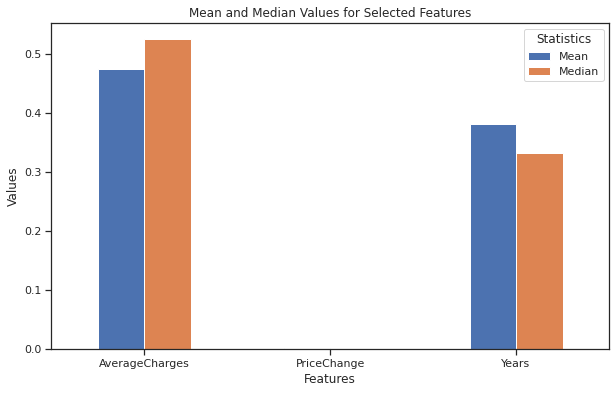

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# Select the features of interest
selected_features = ['AverageCharges', 'PriceChange', 'Years']

# Calculate the mean and median for the selected features
mean_values = X[selected_features].mean()
median_values = X[selected_features].median()

# Create a DataFrame to hold the mean and median values
feature_stats = pd.DataFrame({'Mean': mean_values, 'Median': median_values})

# Plot the grouped bar chart
feature_stats.plot(kind='bar', figsize=(10, 6))
plt.title('Mean and Median Values for Selected Features')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=0)  # Keep the x-axis labels horizontal
plt.legend(title='Statistics', title_fontsize=12)
plt.show()


In [41]:
features = get_features(X, ID, label)
features

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'MultipleLines',
 'DeviceProtection',
 'TechSupport',
 'PaperlessBilling',
 'AverageCharges',
 'PriceChange',
 'Years',
 'NewCustomer',
 'OnlineService',
 'Streaming',
 'Fiber',
 'M2m',
 'OneYearContract',
 'NumberInternetServices',
 'AutomaticPayment',
 'CreditCard',
 'Mail']

In [42]:
numerical_features = X.select_dtypes(include='number').columns.to_list()

bool_features = X.select_dtypes(include='bool').columns.to_list()

assert set(numerical_features + bool_features) == set(features) 

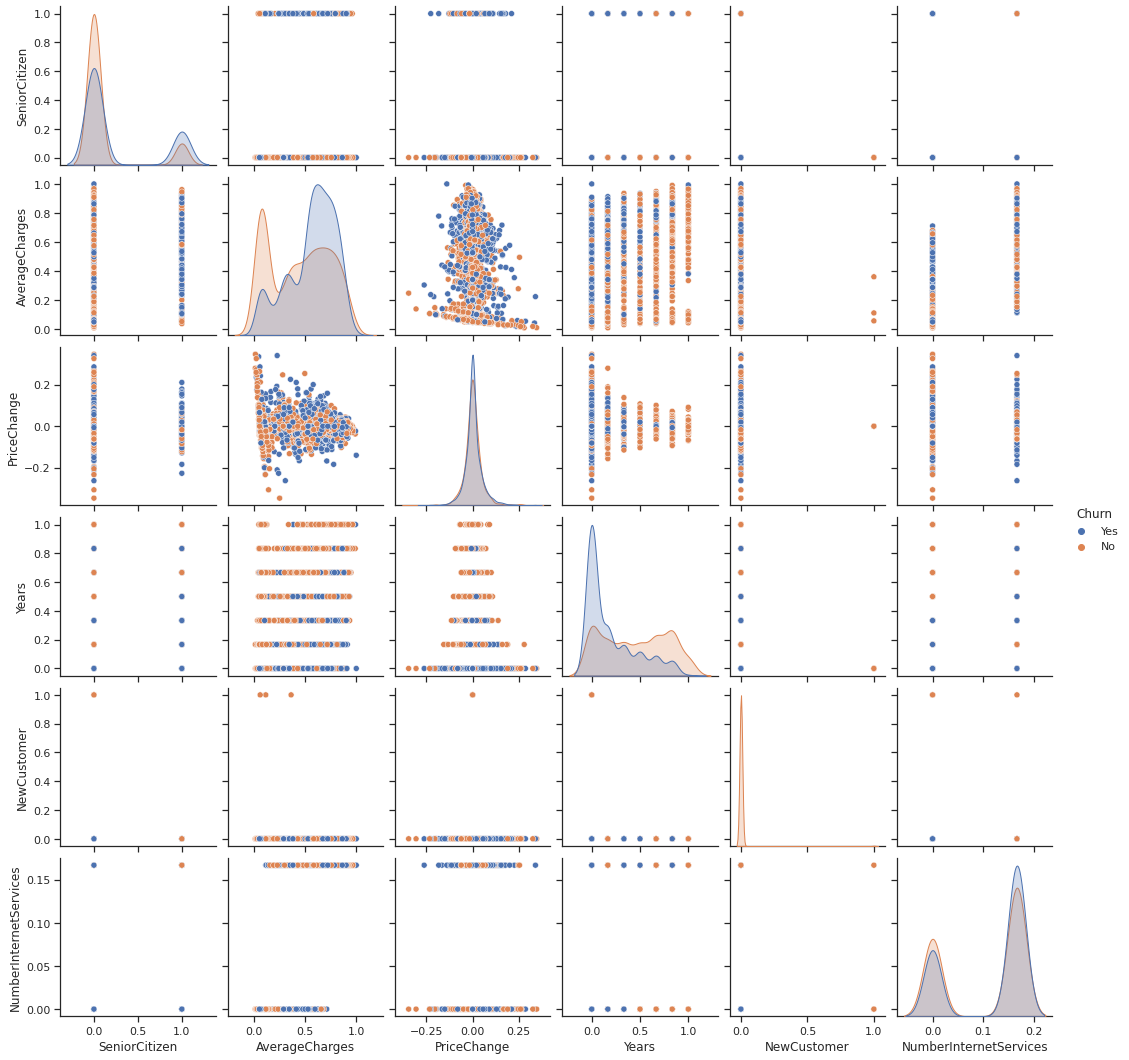

In [43]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)

nYes = X[X.Churn=='Yes'].shape[0]
nNo = nrows - nYes

X_sample = pd.concat([
    X[X.Churn=='Yes'],
    X[X.Churn=='No'].sample(n=nYes)
])[numerical_features + label].sample(frac=1)

sns.pairplot(X_sample, hue="Churn")

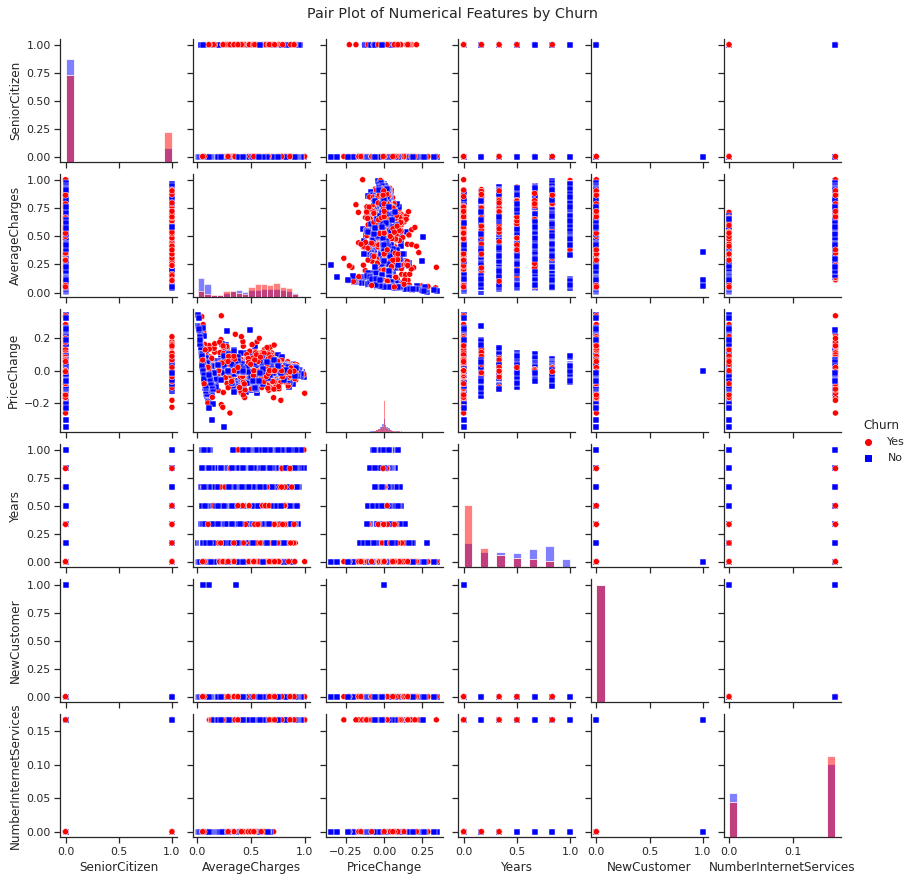

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a custom color palette for "Churn" categories
colors = {'Yes': 'red', 'No': 'blue'}

# Create a pair plot with annotations and enhanced features
pair_plot = sns.pairplot(X_sample, hue="Churn", palette=colors, diag_kind='hist', markers=["o", "s"], height=2)

# Customize the title
pair_plot.fig.suptitle("Pair Plot of Numerical Features by Churn", y=1.02)

# Adjust axis labels
for ax in pair_plot.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend
pair_plot._legend.set_title("Churn")
legend_labels = ["Yes", "No"]
for t, l in zip(pair_plot._legend.texts, legend_labels):
    t.set_text(l)

# Display the pair plot
plt.show()


*Bool features' plots - WIP*

## Section II - Model Training

In [44]:
def display_PrecisionRecallCurve(classifier, X, Y, pos_label = 'Yes'):
    
    from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score
    
    model = classifier['model']
    name = classifier['name']
    
    predict_proba = model.predict_proba(X)
    precision, recall, thresholds = precision_recall_curve(Y==pos_label,
                                                           probas_pred = predict_proba[:,1],
                                                           pos_label=True)
    display = PrecisionRecallDisplay(recall, 
                                     precision, 
                                     estimator_name = name)                                                
    display.plot()
    
    aucpr = average_precision_score((Y==pos_label).values.ravel(), 
                                             model.predict_proba(X)[:,1], 
                                             pos_label=True)
    print('AUCPR - '+ name + ': ', aucpr)
    
    return precision, recall, thresholds, aucpr

AUCPR - Random Forest:  1.0


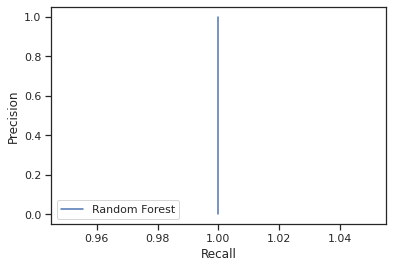

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

def display_PrecisionRecallCurve(classifier, X, Y, pos_label='Yes'):
    from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score

    model = classifier['model']
    name = classifier['name']

    predict_proba = model.predict_proba(X)
    precision, recall, thresholds = precision_recall_curve(Y == pos_label, probas_pred=predict_proba[:, 1], pos_label=True)
    display = PrecisionRecallDisplay(recall, precision, estimator_name=name)
    display.plot()

    aucpr = average_precision_score((Y == pos_label).values.ravel(), model.predict_proba(X)[:, 1], pos_label=True)
    print('AUCPR - ' + name + ': ', aucpr)

    return precision, recall, thresholds, aucpr

# Example usage:
# Load a sample dataset (Iris dataset)
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
Y = pd.Series(iris.target)

# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train a random forest classifier
classifier_dict = {'model': RandomForestClassifier(n_estimators=100, random_state=42), 'name': 'Random Forest'}
classifier_dict['model'].fit(X_train, Y_train)

# Display the Precision-Recall curve for the trained model
precision, recall, thresholds, aucpr = display_PrecisionRecallCurve(classifier_dict, X_test, Y_test, pos_label=1)

# Show the plot
plt.show()


#### Dummy Classifier

AUCPR - dummy:  0.2653532126375577


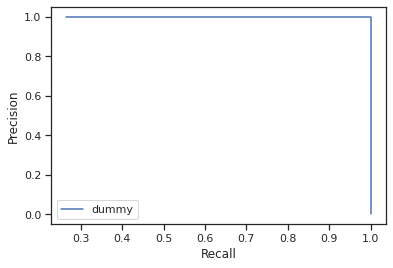

In [45]:
def train_dummy_classifier(train: pd.DataFrame, ID, label):
    
    import matplotlib.pyplot as plt
    from sklearn.dummy import DummyClassifier
    from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score
    
    features = get_features(train, ID, label)
    
    dummy_model = DummyClassifier(strategy='constant', constant='No')
    
    X,Y = train[features], train[label]

    dummy_model.fit(X,Y)
    
    precision, recall, thresholds, aucpr = display_PrecisionRecallCurve(
        {'model':dummy_model,'name':'dummy'}, X,Y
    )
    
    return {'name':'dummy_model',
            'model': dummy_model, 
            'precision': precision, 
            'recall': recall, 
            'thresholds': thresholds, 
            'aucpr': aucpr}

X_train = X
dummy_cl = train_dummy_classifier(X_train, ID, label) 

### Logistic Regression

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 2627 to 1968
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  5634 non-null   bool   
 1   SeniorCitizen           5634 non-null   int64  
 2   Partner                 5634 non-null   bool   
 3   Dependents              5634 non-null   bool   
 4   MultipleLines           5634 non-null   bool   
 5   DeviceProtection        5634 non-null   bool   
 6   TechSupport             5634 non-null   bool   
 7   PaperlessBilling        5634 non-null   bool   
 8   AverageCharges          5634 non-null   float64
 9   PriceChange             5634 non-null   float64
 10  Years                   5634 non-null   float64
 11  NewCustomer             5634 non-null   int64  
 12  OnlineService           5634 non-null   bool   
 13  Streaming               5634 non-null   bool   
 14  Fiber                   5634 non-null

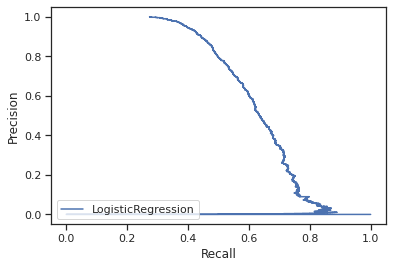

In [46]:
def train_logistic_regression(train: pd.DataFrame, ID, label):
    from sklearn.linear_model import LogisticRegression
    from imblearn.pipeline import make_pipeline
    from imblearn.under_sampling import RandomUnderSampler
    
    from sklearn.model_selection import cross_validate
    from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score

    model = make_pipeline(
        RandomUnderSampler(random_state=0),
        LogisticRegression(solver='sag', max_iter=1000, tol=0.001)
    )
    
    features = get_features(train, ID, label)
    X,Y = train[features], train[label]
    
    print(X.info())
    
    cv_results = cross_validate(estimator = model,X = X.values, y = (Y=='Yes').values.ravel(), 
                                cv = 7, scoring = ['average_precision','precision','recall'],
                                return_estimator = True, return_train_score = True
                               )
    
    model = make_pipeline(
        RandomUnderSampler(random_state=0),
        LogisticRegression(solver='sag', max_iter=1000, tol=0.0001)
    )
    
    model.fit(X, (Y=='Yes').values.ravel())
    
    precision = {
        'avg':np.mean(cv_results['test_precision']),
        'std': np.std(cv_results['test_precision'])
    }
    
    recall = {
        'avg':np.mean(cv_results['test_recall']),
        'std': np.std(cv_results['test_recall'])
    }
    
    aucpr = {
        'avg':np.mean(cv_results['test_average_precision']),
        'std': np.std(cv_results['test_average_precision'])
    }
    
    
    _ = display_PrecisionRecallCurve(
        {'name':'LogisticRegression',
         'model': model['logisticregression']}, 
        X,Y
    )
    
    return {'name':'LogisticRegression',
    'model': model['logisticregression'], 
            'precision': precision, 
            'recall': recall, 
            'aucpr': aucpr}

X_train = X
logistic_cl = train_logistic_regression(X_train, ID, label)

print('\n'+logistic_cl['name']+'\n')
print('AUCPR (training):',logistic_cl['aucpr']['avg'],' (+/- ',round(logistic_cl['aucpr']['std'],5),')')

<AxesSubplot:title={'center':'Feature Importance for LogisticRegression'}, xlabel='Feature'>

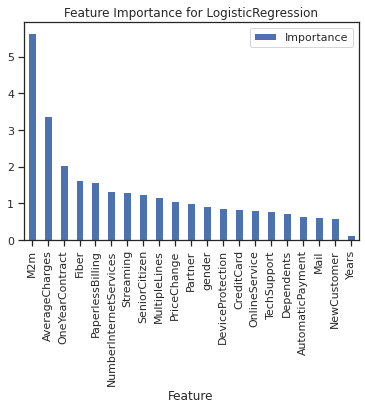

In [47]:
model = logistic_cl['model']

feature_importance = pd.DataFrame(list(zip(features,np.exp(model.coef_[0]))), columns = ['Feature','Importance'])
feature_importance.sort_values(by = 'Importance',ascending = False).plot.bar(x='Feature', title = 'Feature Importance for ' + logistic_cl['name'])


### LightGBM

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 2627 to 1968
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  5634 non-null   bool   
 1   SeniorCitizen           5634 non-null   int64  
 2   Partner                 5634 non-null   bool   
 3   Dependents              5634 non-null   bool   
 4   MultipleLines           5634 non-null   bool   
 5   DeviceProtection        5634 non-null   bool   
 6   TechSupport             5634 non-null   bool   
 7   PaperlessBilling        5634 non-null   bool   
 8   AverageCharges          5634 non-null   float64
 9   PriceChange             5634 non-null   float64
 10  Years                   5634 non-null   float64
 11  NewCustomer             5634 non-null   int64  
 12  OnlineService           5634 non-null   bool   
 13  Streaming               5634 non-null   bool   
 14  Fiber                   5634 non-null

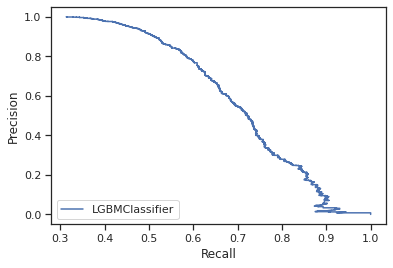

In [48]:
def train_lgb(train: pd.DataFrame, ID, label):
    from lightgbm import LGBMClassifier
    from imblearn.pipeline import make_pipeline
    from imblearn.under_sampling import RandomUnderSampler
    
    from sklearn.model_selection import cross_validate
    
    from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score
    
    model = make_pipeline(
        #RandomUnderSampler(),
        LGBMClassifier(boosting_type='gbdt', n_estimators = 50, 
                       max_depth = 3, learning_rate= 0.3, is_unbalance = True)
    )
    
    features = get_features(train, ID, label)
    X,Y = train[features], train[label]
    
    print(X.info())
    
    cv_results = cross_validate(estimator = model,X = X.values, y = (Y=='Yes').values.ravel(), 
                                cv = 7, scoring = ['average_precision','precision','recall'],
                                return_estimator = True, return_train_score = True
                               )
    
    model = make_pipeline(
        #RandomUnderSampler(random_state=0),
        LGBMClassifier(boosting_type='gbdt', n_estimators = 50, 
                       max_depth = 3, learning_rate= 0.3, is_unbalance = True)
    )
    
    model.fit(X, (Y=='Yes').values.ravel())
    
    precision = {
        'avg':np.mean(cv_results['test_precision']),
        'std': np.std(cv_results['test_precision'])
    }
    
    recall = {
        'avg':np.mean(cv_results['test_recall']),
        'std': np.std(cv_results['test_recall'])
    }
    
    aucpr = {
        'avg':np.mean(cv_results['test_average_precision']),
        'std': np.std(cv_results['test_average_precision'])
    }
    
    _ = display_PrecisionRecallCurve(
        {'name':'LGBMClassifier',
         'model': model['lgbmclassifier']}, 
        X,Y
    )
    
    print(model)
    return {'name':'LGBMClassifier', 'model':model['lgbmclassifier'],'precision':precision,'recall':recall,'aucpr':aucpr}


lgb_cl = train_lgb(X_train, ID, label)
lgb_cl

print('\n'+lgb_cl['name']+'\n')
print('AUCPR (training):',lgb_cl['aucpr']['avg'],' (+/- ',round(lgb_cl['aucpr']['std'],5),')')

<AxesSubplot:xlabel='Feature'>

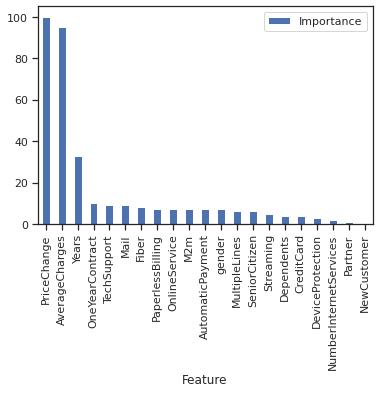

In [49]:
feature_importance = pd.DataFrame(
    list(zip(lgb_cl['model'].feature_importances_, lgb_cl['model'].feature_name_)),
    columns=['Importance','Feature'])
feature_importance.sort_values(by='Importance', ascending=False).plot.bar(x='Feature')

### SVC Model

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 2627 to 1968
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  5634 non-null   bool   
 1   SeniorCitizen           5634 non-null   int64  
 2   Partner                 5634 non-null   bool   
 3   Dependents              5634 non-null   bool   
 4   MultipleLines           5634 non-null   bool   
 5   DeviceProtection        5634 non-null   bool   
 6   TechSupport             5634 non-null   bool   
 7   PaperlessBilling        5634 non-null   bool   
 8   AverageCharges          5634 non-null   float64
 9   PriceChange             5634 non-null   float64
 10  Years                   5634 non-null   float64
 11  NewCustomer             5634 non-null   int64  
 12  OnlineService           5634 non-null   bool   
 13  Streaming               5634 non-null   bool   
 14  Fiber                   5634 non-null

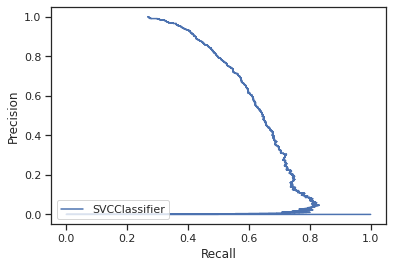

In [50]:
def train_svc(train: pd.DataFrame, ID, label):
    from sklearn.svm import SVC
    from imblearn.pipeline import make_pipeline
    from imblearn.under_sampling import RandomUnderSampler
    
    from sklearn.model_selection import cross_validate
    
    from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score
    
    model = make_pipeline(
        RandomUnderSampler(),
        SVC(kernel='rbf', gamma = 'auto', C = 1, probability = True)
    )
    
    features = get_features(train, ID, label)
    X,Y = train[features], train[label]
    
    print(X.info())
    
    cv_results = cross_validate(estimator = model,X = X.values, y = (Y=='Yes').values.ravel(), 
                                cv = 7, scoring = ['average_precision','precision','recall'],
                                return_estimator = True, return_train_score = True
                               )
    
    model = make_pipeline(
        RandomUnderSampler(random_state=0),
        SVC(kernel='rbf', gamma = 'auto', C = 1e-1, probability = True)
    )
    
    model.fit(X, (Y=='Yes').values.ravel())
    
    precision = {
        'avg':np.mean(cv_results['test_precision']),
        'std': np.std(cv_results['test_precision'])
    }
    
    recall = {
        'avg':np.mean(cv_results['test_recall']),
        'std': np.std(cv_results['test_recall'])
    }
    
    aucpr = {
        'avg':np.mean(cv_results['test_average_precision']),
        'std': np.std(cv_results['test_average_precision'])
    }
    
    _ = display_PrecisionRecallCurve(
        {'name':'SVCClassifier',
         'model': model['svc']}, 
        X,Y
    )
    
    print(model)
    return {'name':'SVCClassifier', 'model':model['svc'],'precision':precision,'recall':recall,'aucpr':aucpr}


svc_cl = train_svc(X_train, ID, label)
svc_cl

print('\n'+lgb_cl['name']+'\n')
print('AUCPR (training):',svc_cl['aucpr']['avg'],' (+/- ',round(svc_cl['aucpr']['std'],5),')')

In [51]:
lgb_cl, logistic_cl, svc_cl

({'name': 'LGBMClassifier',
  'model': LGBMClassifier(is_unbalance=True, learning_rate=0.3, max_depth=3,
                 n_estimators=50),
  'precision': {'avg': 0.5092364596903864, 'std': 0.02116155630889959},
  'recall': {'avg': 0.7913054651898932, 'std': 0.02721973699515821},
  'aucpr': {'avg': 0.6430626626157837, 'std': 0.02763469640294683}},
 {'name': 'LogisticRegression',
  'model': LogisticRegression(max_iter=1000, solver='sag'),
  'precision': {'avg': 0.5025389568449586, 'std': 0.019610287654567723},
  'recall': {'avg': 0.7986579915630856, 'std': 0.014228320085619892},
  'aucpr': {'avg': 0.6204082518444665, 'std': 0.012824905177268569}},
 {'name': 'SVCClassifier',
  'model': SVC(C=0.1, gamma='auto', probability=True),
  'precision': {'avg': 0.4383762436046657, 'std': 0.01577253528457027},
  'recall': {'avg': 0.8782414110833224, 'std': 0.016200310859163274},
  'aucpr': {'avg': 0.6173615714016305, 'std': 0.015191848618586145}})

TypeError: list() takes no keyword arguments

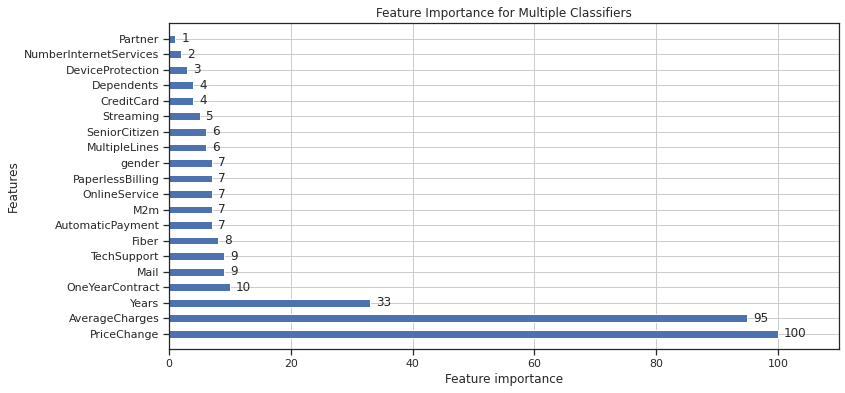

In [83]:
import lightgbm as lgb

# Create a function to plot feature importance for a given classifier
def plot_feature_importance(classifier, features, title):
    if 'coef_' in dir(classifier['model']):
        # For linear models like Logistic Regression and SVC
        model = classifier['model']
        feature_importance = pd.DataFrame(list(zip(features, np.exp(model.coef_[0])), columns=['Feature', 'Importance']))
        feature_importance_sorted = feature_importance.sort_values(by='Importance', ascending=False)

        plt.barh(feature_importance_sorted['Feature'], feature_importance_sorted['Importance'], label=classifier['name'])
    elif isinstance(classifier['model'], lgb.LGBMClassifier):
        # For LightGBM
        model = classifier['model']
        lgb.plot_importance(model, importance_type='split', title=title, height=0.5, ax=plt.gca())
        plt.gca().invert_yaxis()  # Invert y-axis for better visualization
    else:
        print(f"Feature importance not supported for {classifier['name']}")

# Combine classifiers and their feature importances
classifiers = [lgb_cl, logistic_cl, svc_cl]

# Create a figure and plot feature importance for each classifier
plt.figure(figsize=(12, 6))

for classifier in classifiers:
    plot_feature_importance(classifier, features, title='Feature Importance for Multiple Classifiers')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()


### Apply Models on Validation Set

AUCPR - LGBMClassifier:  0.7063933957310479
AUCPR - LogisticRegression:  0.6231187964157062
AUCPR - SVCClassifier:  0.6192501651327663


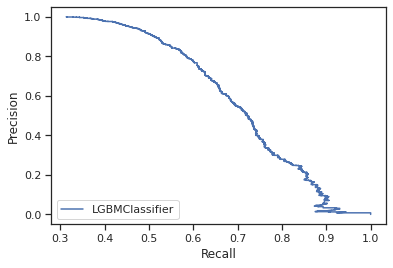

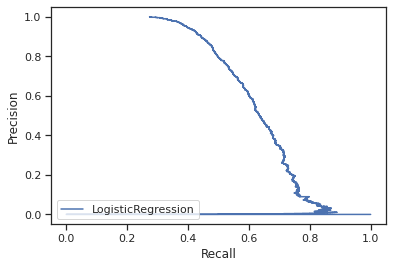

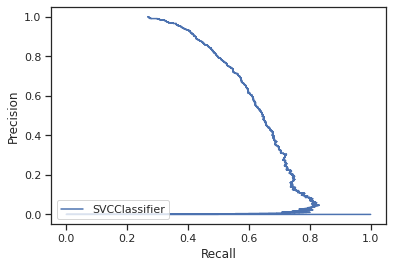

In [52]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score

for classifier in [lgb_cl, logistic_cl, svc_cl]:
    model = classifier['model']
    name = classifier['name']
    
    _ = display_PrecisionRecallCurve(
        {'name':name,
         'model': model}, 
        X[features],X[label]
    )

## Explain Prediction

WIP

#### Feature Importance (model specific)

No.0: gender
No.1: SeniorCitizen
No.2: Partner
No.3: Dependents
No.4: MultipleLines
No.5: DeviceProtection
No.6: TechSupport
No.7: PaperlessBilling
No.8: AverageCharges
No.9: PriceChange
No.10: Years
No.11: NewCustomer
No.12: OnlineService
No.13: Streaming
No.14: Fiber
No.15: M2m
No.16: OneYearContract
No.17: NumberInternetServices
No.18: AutomaticPayment
No.19: CreditCard
No.20: Mail


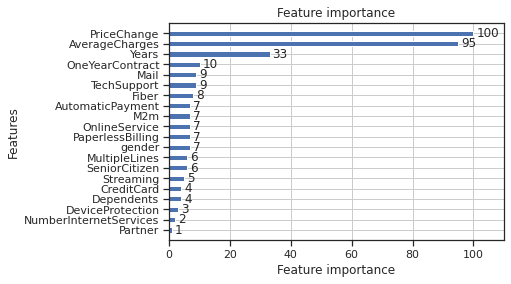

In [53]:
from lightgbm import plot_importance

model = lgb_cl['model']
features = lgb_cl['model'].feature_name_

plot_importance(lgb_cl['model'], height = 0.5)

for n,feature in enumerate(features):
    print('No.'+ str(n)+': '+feature)

#### Partial Dependence Plot (sklearn)

<AxesSubplot:title={'center':'Years PDP'}, xlabel='x'>

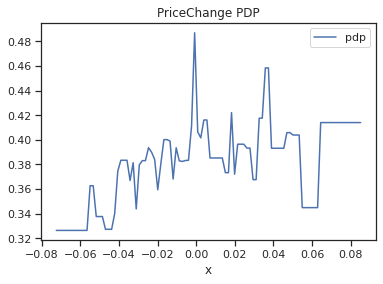

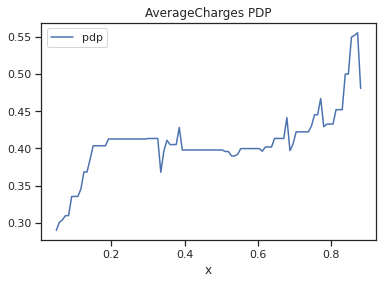

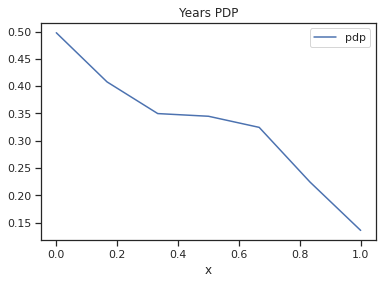

In [54]:
from sklearn.inspection import partial_dependence, plot_partial_dependence


pdp,axes = partial_dependence(model, X_val[features], ['PriceChange'])
PriceChange_PDP = pd.DataFrame({'x':axes[0],'pdp':pdp[0]})
PriceChange_PDP.plot.line(x='x',y='pdp', title='PriceChange PDP')

pdp,axes = partial_dependence(model, X_val[features], ['AverageCharges'])
AverageCharges_PDP = pd.DataFrame({'x':axes[0],'pdp':pdp[0]})
AverageCharges_PDP.plot.line(x='x',y='pdp', title='AverageCharges PDP')


pdp,axes = partial_dependence(model, X_val[features], ['Years'])
Years_PDP = pd.DataFrame({'x':axes[0],'pdp':pdp[0]})
Years_PDP.plot.line(x='x',y='pdp', title='Years PDP')


#### Shap Values (shap)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


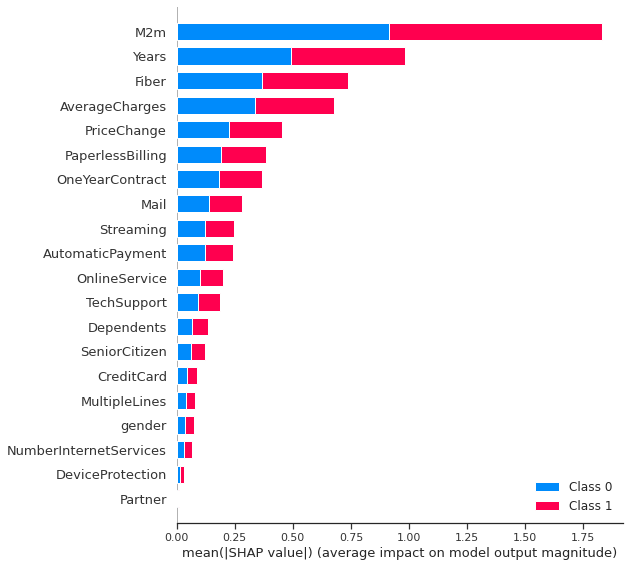

True

In [55]:
import shap

model = lgb_cl['model']

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val[features])
expected_value = explainer.expected_value


############## visualizations #############
# Generate summary dot plot
shap.summary_plot(shap_values, X_val[features],title="SHAP summary plot",plot_type='bar') 


"""# Generate waterfall plot  
shap.plots._waterfall.waterfall_legacy(expected_value[0], 
                                       shap_values[0], 
                                       features=X[features].loc[0,:], feature_names=features, max_display=15, show=True)"""


"""# Generate dependence plot
for name in X_val.columns:
     shap.dependence_plot(name, shap_values, X_val)"""
"""
# Generate force plot - Multiple rows 
shap.force_plot(explainer.expected_value, shap_values[:100,:], X_val[features].iloc[:100,:])"""

True

#### Lime

In [56]:
import lime
import lime.lime_tabular
istance_number = 0

############## create explainer ###########
# we use the dataframes splits created above for SHAP
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_val[features].to_numpy(), feature_names=X_val[features], class_names=['No','Yes'], verbose=True)

############## visualizations #############
exp = lime_explainer.explain_instance(X_val[features].iloc[istance_number,:], model.predict_proba, num_features=20)
exp.show_in_notebook(show_table=True)

Intercept -0.13629841010810873
Prediction_local [0.76074702]
Right: 0.8136348536113687


Intercept -0.061538700214001485
Prediction_local [0.75752799]
Right: 0.8136348536113687


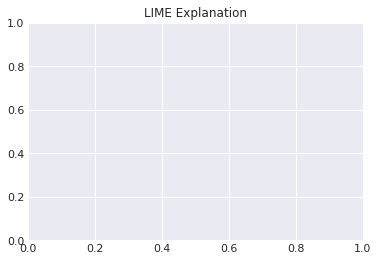

In [97]:
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

instance_number = 0

# Create a LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_val[features].to_numpy(),
                                                      mode="classification",
                                                      feature_names=features,
                                                      class_names=['No', 'Yes'],
                                                      verbose=True)

# Create an explanation for the selected instance
explanation = lime_explainer.explain_instance(X_val[features].iloc[instance_number, :],
                                              model.predict_proba,
                                              num_features=20)

# Show the explanation table
explanation.show_in_notebook(show_table=True)

# Generate custom visualizations using matplotlib

plt.title("LIME Explanation")
plt.show()


#### Counterfactual (DiCE)

In [ ]:
!pip install dice-ml

In [ ]:
instance_number = 1

# Generate counterfactual examples
dice_exp = exp.generate_counterfactuals(
    dataframe[features][1:2], 
    total_CFs=4, 
    desired_class='opposite',
)
# Visualize counterfactual explanation
dice_exp.visualize_as_dataframe(show_only_changes=True)


In [ ]:
instance_number = 1

predicted_outcome = np.array(list(map(lambda x: np.argmax(x),
                                      m.get_output(dataframe[features])
                                     ))).reshape(-1,1)

# Generate counterfactual examples
dice_exp = exp.generate_counterfactuals(
    dataframe[predicted_outcome==1][features][5:6], 
    total_CFs=4, 
    desired_class=0,
    features_to_vary = ['Partner','PriceChange']
)
# Visualize counterfactual explanation
dice_exp.visualize_as_dataframe(show_only_changes=True)
